
Analyzing confirm_transaction_4.wav


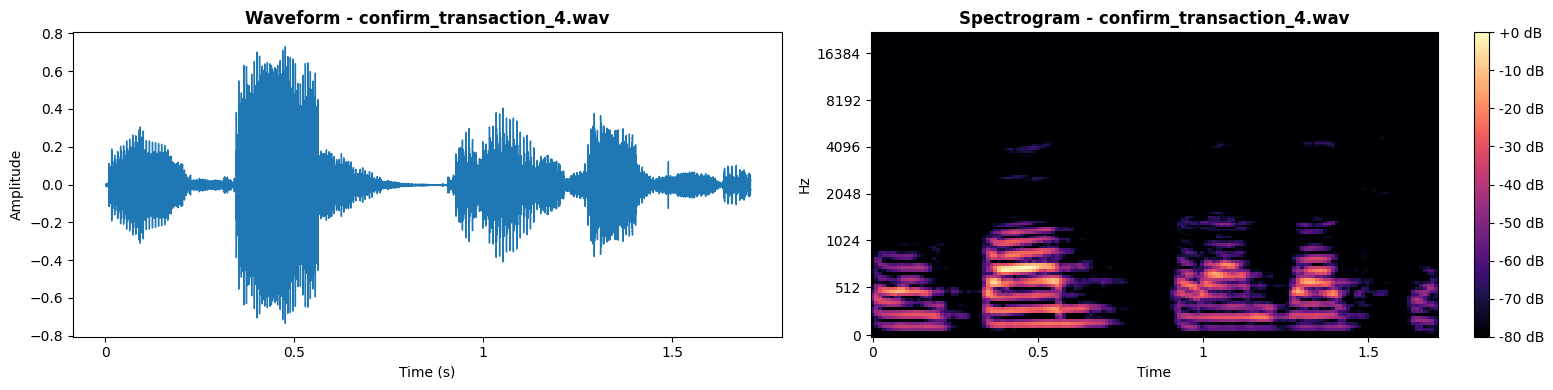

Successfully processed confirm_transaction_4.wav

Analyzing yes_approve_2.wav


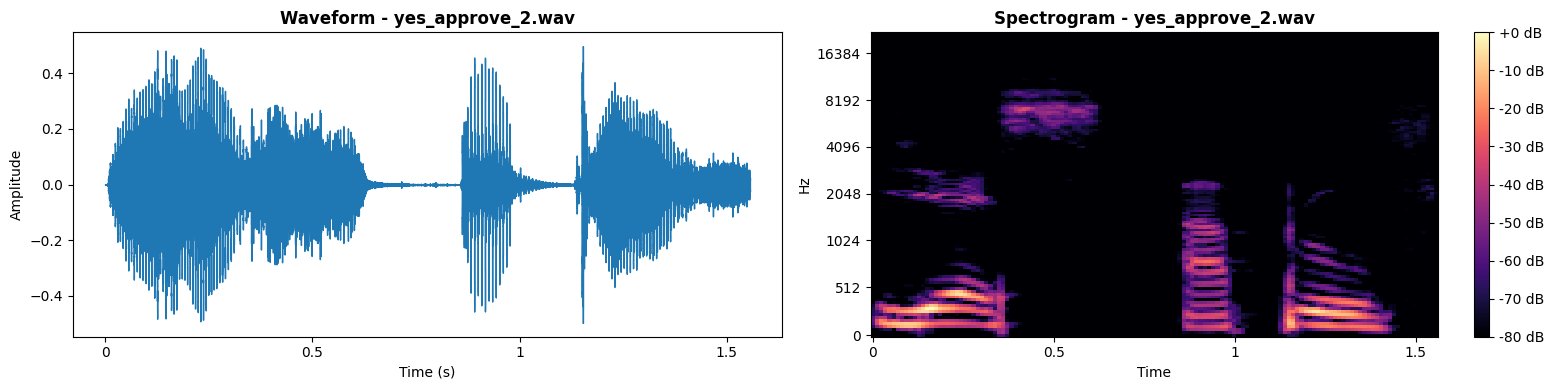

Successfully processed yes_approve_2.wav

Analyzing confirm_transaction_2.wav


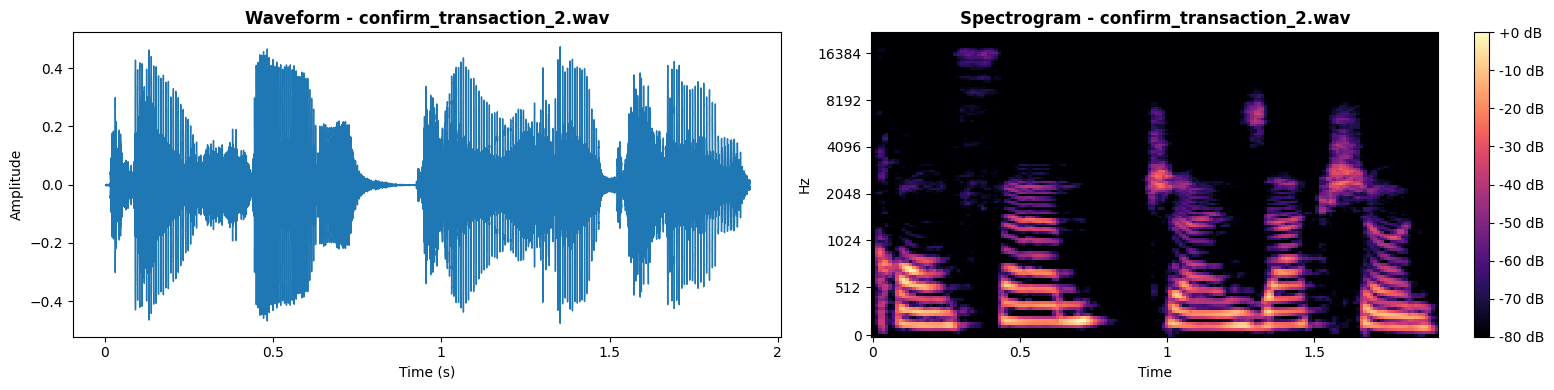

Successfully processed confirm_transaction_2.wav

Analyzing yes_approve_1.wav


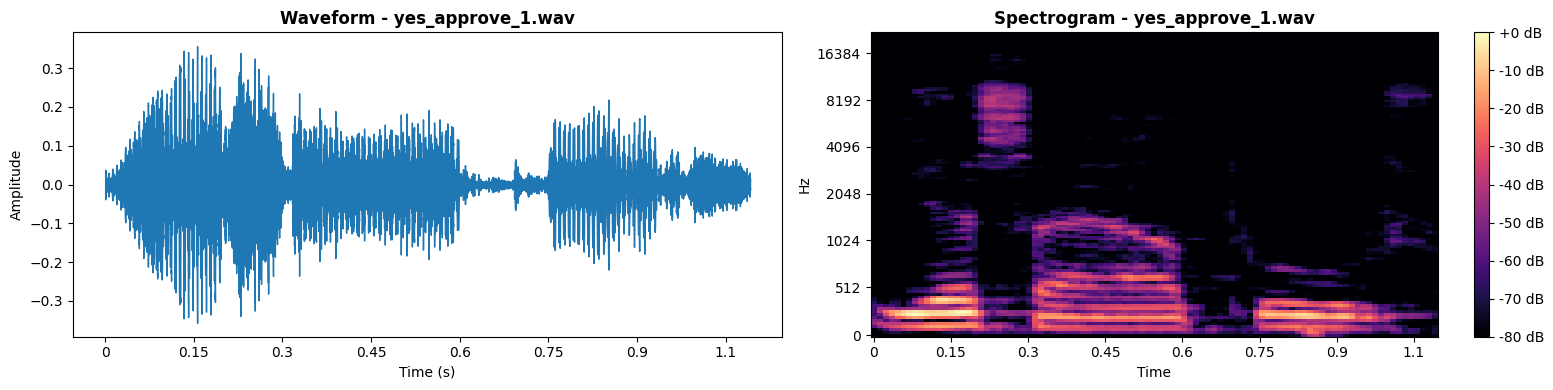

Successfully processed yes_approve_1.wav

Analyzing confirm_transaction_1.wav


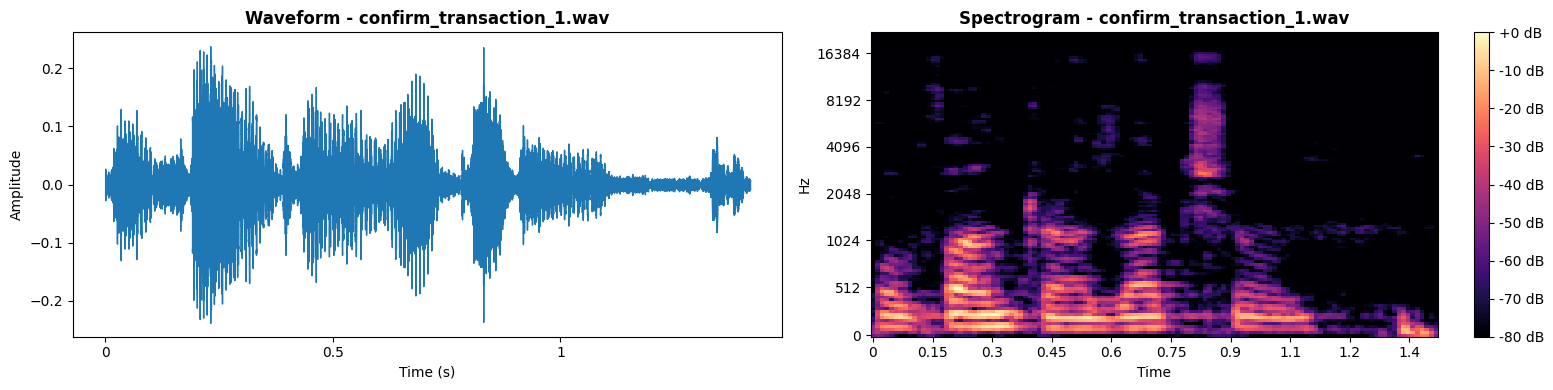

Successfully processed confirm_transaction_1.wav

Analyzing yes_approve_4.wav


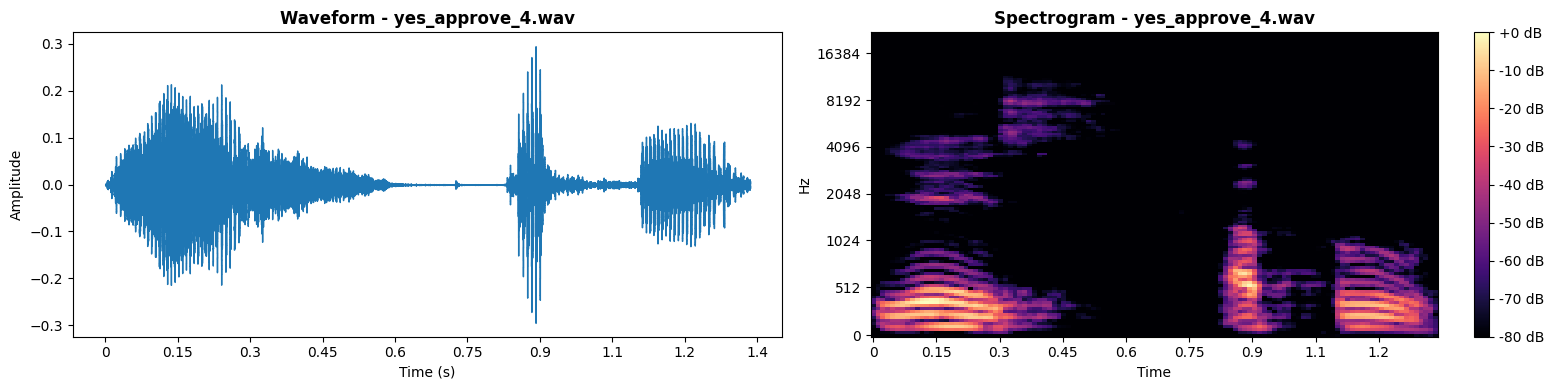

Successfully processed yes_approve_4.wav

Analyzing confirm_transaction_3.wav


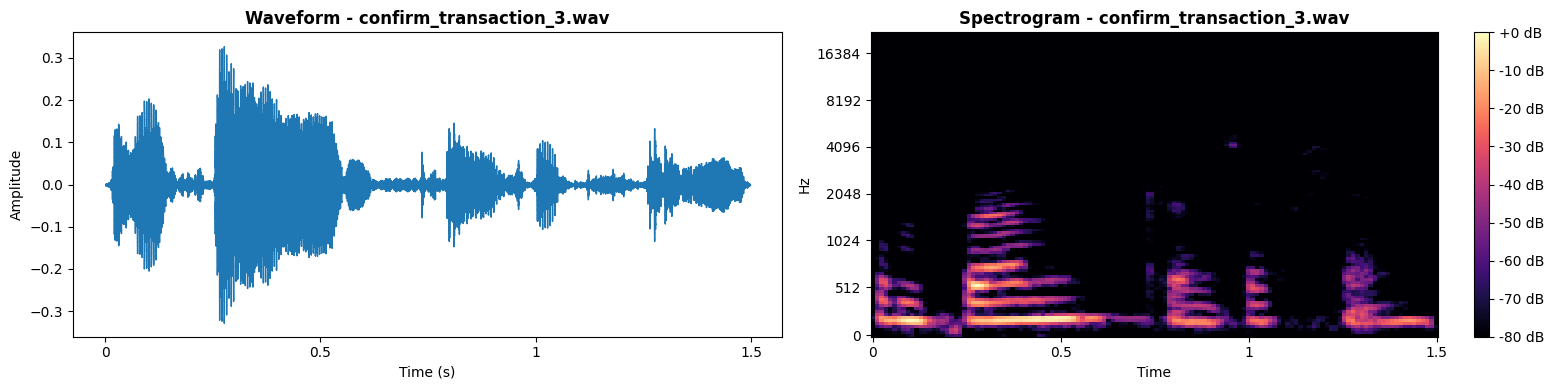

Successfully processed confirm_transaction_3.wav

Analyzing yes_approve_3.wav


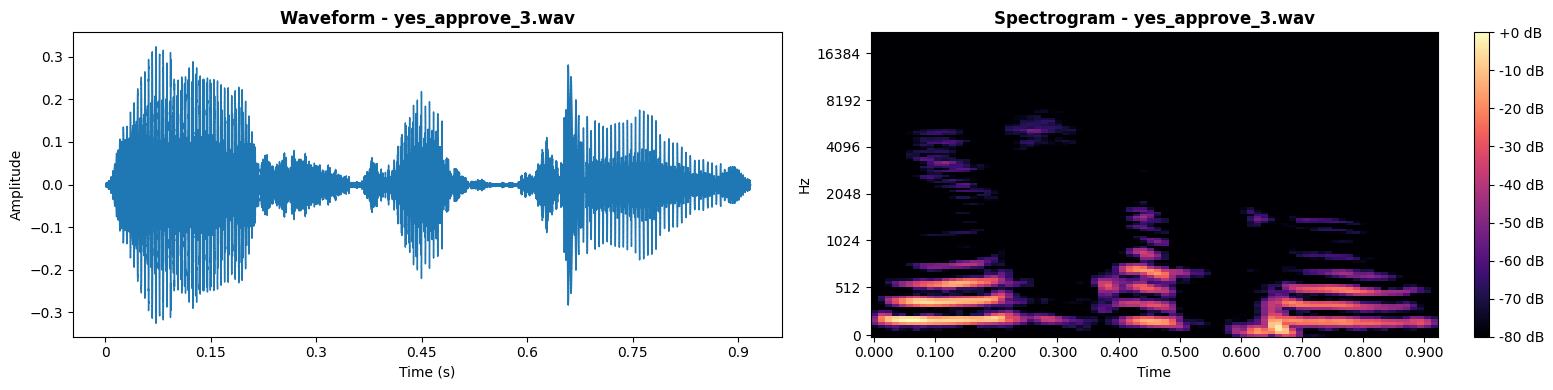

Successfully processed yes_approve_3.wav

SUMMARY

Feature extraction complete. Saved to 'audio_features.csv'
Total features extracted: 32 (original + augmented)
Processed 8/8 files successfully.

First 5 rows of extracted features:
                    filename                type      mfcc_1      mfcc_2  \
0  confirm_transaction_4.wav            original -315.653656  156.606110   
1  confirm_transaction_4.wav     pitch_shift(+2) -338.472717  146.733475   
2  confirm_transaction_4.wav  time_stretch(1.2x) -340.187592  152.198563   
3  confirm_transaction_4.wav               noisy -240.173755   92.669777   
4          yes_approve_2.wav            original -306.546722   87.117172   

      mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7     mfcc_8  \
0  14.158589  27.842001  -4.530815 -18.956953 -19.474596   3.405268   
1  14.364845  22.542364 -14.068079 -23.629154 -11.923103   3.047389   
2  18.328226  28.774952  -4.761503 -20.569231 -19.101992   1.529654   
3  31.768971  20.089116  -

In [2]:
import os
import requests
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ----------------------------
# STEP 1: Download audio files from GitHub
# ----------------------------
GITHUB_API_URL = "https://api.github.com/repos/fadhuweb/ML_pipeline_formative_2/contents/data/audio"
SAVE_DIR = "audio_files"
os.makedirs(SAVE_DIR, exist_ok=True)

# Define supported audio formats
SUPPORTED_FORMATS = [".wav"]

response = requests.get(GITHUB_API_URL)
if response.status_code == 200:
    files = response.json()
    for file in files:
        # Check if file has any supported audio format
        if any(file["name"].lower().endswith(fmt) for fmt in SUPPORTED_FORMATS):
            print(f"Downloading {file['name']}...")
            audio_data = requests.get(file["download_url"]).content
            file_path = os.path.join(SAVE_DIR, file["name"])
            with open(file_path, "wb") as f:
                f.write(audio_data)
else:
    raise Exception(f"Failed to fetch file list: {response.status_code}")

# ----------------------------
# STEP 2: Feature extraction helper
# ----------------------------
def extract_features(y, sr):
    """Extract MFCCs, spectral rolloff, and RMS energy"""
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    rms = np.mean(librosa.feature.rms(y=y))
    return mfccs, spectral_rolloff, rms

# ----------------------------
# STEP 3: Process audio files
# ----------------------------
audio_files = [f for f in os.listdir(SAVE_DIR)
               if any(f.lower().endswith(fmt) for fmt in SUPPORTED_FORMATS)]

if not audio_files:
    raise Exception("No audio files found in the folder.")

all_features = []
failed_files = []

for audio_file in audio_files:
    file_path = os.path.join(SAVE_DIR, audio_file)
    print(f"\n{'='*60}")
    print(f"Analyzing {audio_file}")
    print('='*60)

    try:
        y, sr = librosa.load(file_path, sr=None)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        # ---- Visualization: Waveform and Spectrogram side by side ----
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))

        # Waveform
        librosa.display.waveshow(y_trimmed, sr=sr, ax=axes[0])
        axes[0].set_title(f"Waveform - {audio_file}", fontsize=12, fontweight='bold')
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Amplitude")

        # Spectrogram
        S = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)
        S_db = librosa.amplitude_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel", ax=axes[1])
        axes[1].set_title(f"Spectrogram - {audio_file}", fontsize=12, fontweight='bold')
        fig.colorbar(img, ax=axes[1], format="%+2.0f dB")

        plt.tight_layout()
        plt.show()

        # ---- Extract features ----
        mfccs, rolloff, rms = extract_features(y_trimmed, sr)
        features = {
            "filename": audio_file,
            "type": "original",
            **{f"mfcc_{i+1}": mfccs[i] for i in range(13)},
            "spectral_rolloff": rolloff,
            "rms_energy": rms
        }
        all_features.append(features)

        # ----------------------------
        # STEP 4: Data Augmentation
        # ----------------------------

        # Pitch shift
        y_pitch = librosa.effects.pitch_shift(y_trimmed, sr=sr, n_steps=2)
        mfccs, rolloff, rms = extract_features(y_pitch, sr)
        features_pitch = {
            "filename": audio_file,
            "type": "pitch_shift(+2)",
            **{f"mfcc_{i+1}": mfccs[i] for i in range(13)},
            "spectral_rolloff": rolloff,
            "rms_energy": rms
        }
        all_features.append(features_pitch)

        # Time stretch
        y_stretch = librosa.effects.time_stretch(y_trimmed, rate=1.2)
        mfccs, rolloff, rms = extract_features(y_stretch, sr)
        features_stretch = {
            "filename": audio_file,
            "type": "time_stretch(1.2x)",
            **{f"mfcc_{i+1}": mfccs[i] for i in range(13)},
            "spectral_rolloff": rolloff,
            "rms_energy": rms
        }
        all_features.append(features_stretch)

        # Add noise
        noise = np.random.normal(0, 0.005, len(y_trimmed))
        y_noisy = y_trimmed + noise
        mfccs, rolloff, rms = extract_features(y_noisy, sr)
        features_noise = {
            "filename": audio_file,
            "type": "noisy",
            **{f"mfcc_{i+1}": mfccs[i] for i in range(13)},
            "spectral_rolloff": rolloff,
            "rms_energy": rms
        }
        all_features.append(features_noise)

        print(f"Successfully processed {audio_file}")

    except Exception as e:
        print(f"Failed to process {audio_file}: {str(e)}")
        failed_files.append((audio_file, str(e)))
        continue

# ----------------------------
# STEP 5: Save all features to CSV
# ----------------------------
print(f"\n{'='*60}")
print("SUMMARY")
print('='*60)

if all_features:
    df = pd.DataFrame(all_features)
    csv_path = "audio_features.csv"
    df.to_csv(csv_path, index=False)
    print(f"\nFeature extraction complete. Saved to '{csv_path}'")
    print(f"Total features extracted: {len(all_features)} (original + augmented)")
    print(f"Processed {len(audio_files) - len(failed_files)}/{len(audio_files)} files successfully.")

    # Display first few rows of the dataframe
    print(f"\nFirst 5 rows of extracted features:")
    print(df.head())
else:
    print("\nNo features extracted. All files failed to process.")

if failed_files:
    print("\nFailed files:")
    for filename, error in failed_files:
        print(f"  - {filename}: {error}")